<a href="https://colab.research.google.com/github/albertfast/lunar_lender_v3/blob/main/lunar_lender_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
# 🌕 Lunar Lander - Reinforcement Learning Mission

Welcome! In this notebook, we explore a trained Reinforcement Learning agent landing a module safely on the Moon.

Instead of training from scratch, you will run simulations of **10 pre-trained models**, compare their performance, and watch the **best-performing one in action**.

To begin, run each cell below step-by-step. Let's go! 🚀
"""

In [23]:
!apt-get install -y swig cmake
!pip install box2d-py gymnasium[box2d] pygame imageio imageio-ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import imageio
import imageio.v3 as iio
from rich.console import Console
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
console = Console()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def extract_episode(filename):
    return int(filename.split("_")[-1].split(".")[0])

def test_model(env, model, max_frames=1000):
    frames = []
    state, _ = env.reset()
    total_reward = 0
    for _ in range(max_frames):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            action = model(state_tensor).argmax(1).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        frames.append(env.render())
        state = next_state
        if terminated or truncated:
            break
    return total_reward, frames

In [29]:
import os, shutil, torch, pickle, imageio, random
import gymnasium as gym
from rich.console import Console
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image, display
from collections import namedtuple

# === Transition Definition ===
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# === Configs ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = "/content/drive/MyDrive/ColabNotebooks/lunar_models"
GIF_DIR = "/content/drive/MyDrive/ColabNotebooks/lunar_outputs/gifs"
MP4_DIR = "/content/drive/MyDrive/ColabNotebooks/lunar_outputs/mp4s"
DRIVE_DIR = "/content/drive/MyDrive/ColabNotebooks/lunar_outputs"
MAX_FRAMES = 1000
console = Console()

# === Utils ===
def extract_episode(filename):
    return int(filename.split("_")[-1].split(".")[0])

def load_buffer(path):
    try:
        return torch.load(path, map_location=DEVICE, weights_only=False)
    except Exception as e:
        console.print(f"[red]Buffer load failed: {e}[/red]")
        return None

def test_model(env, model):
    frames, total_reward = [], 0
    state, _ = env.reset()
    for _ in range(MAX_FRAMES):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            action = model(state_tensor).argmax(1).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        frames.append(env.render())
        state = next_state
        if terminated or truncated:
            break
    return total_reward, frames

def display_video(video):
    fig = plt.figure(figsize=(5, 5), frameon=False)
    mov = []
    for i in range(len(video)):
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ani = animation.ArtistAnimation(fig, mov, interval=30, repeat_delay=1000)
    plt.close()
    return ani

def to_scalar(value):
    if value is None:
        return 0.0
    if torch.is_tensor(value):
        if value.numel() == 1:
            return value.item()
        else:
            return value.mean().item()
    return float(value) if isinstance(value, (int, float)) else 0.0

# === MAIN ===
env = gym.make("LunarLander-v3", render_mode="rgb_array")
results = []

for model_file in sorted(os.listdir(MODEL_DIR)):
    if not model_file.startswith("policy_net_best_") or not model_file.endswith(".pth"):
        continue

    episode = extract_episode(model_file)
    policy_path = os.path.join(MODEL_DIR, f"policy_net_best_{episode}.pth")
    target_path = os.path.join(MODEL_DIR, f"target_net_best_{episode}.pth")

    # Dynamically find buffer
    possible_buffers = [
        f"buffer_net_best_{episode}.pkl",
        f"buffer_best_{episode}.pkl",
        f"buffer_{episode}.pkl"
    ]
    buffer_path = next((os.path.join(MODEL_DIR, name) for name in possible_buffers if os.path.exists(os.path.join(MODEL_DIR, name))), None)

    # Load Policy Net
    policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
    policy_net.load_state_dict(torch.load(policy_path, map_location=DEVICE))
    policy_net.eval()

    # Load Target Net
    if os.path.exists(target_path):
        target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
        target_net.load_state_dict(torch.load(target_path, map_location=DEVICE))
        target_net.eval()

    # Load Buffer
    buffer = load_buffer(buffer_path) if buffer_path is not None else None

    if buffer:
        buffer_len = len(buffer)
        console.print(f"[yellow]🧠 Buffer found for episode {episode} ({buffer_len} transitions)[/yellow]")
        samples = random.sample(buffer, min(3, buffer_len))

        for i, (state, action, reward, next_state, done) in enumerate(samples):
            if isinstance(state, torch.Tensor):
                state_tensor = state.float().unsqueeze(0).to(DEVICE)
            else:
                state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)

            q_values = policy_net(state_tensor)
            q_avg = q_values.mean().item()

            action_val = to_scalar(action)
            reward_val = to_scalar(reward)

            console.print(f"[green]🔹 Sample {i+1} — Action: {action_val}, Reward: {reward_val:.2f}, Q-avg: {q_avg:.2f}[/green]")
    else:
        console.print(f"[blue]ℹ️ No buffer found for episode {episode}. Proceeding without it.[/blue]")

    reward, frames = test_model(env, policy_net)
    results.append((episode, reward, frames))
    console.print(f"✅ Episode {episode}: Reward = {reward:.2f}")

# === Save best
best_episode, best_reward, best_frames = sorted(results, key=lambda x: x[1], reverse=True)[0]
gif_name = f"episode_{best_episode}_reward_{int(best_reward)}.gif"
mp4_name = f"episode_{best_episode}_reward_{int(best_reward)}.mp4"

gif_path = os.path.join(GIF_DIR, gif_name)
mp4_path = os.path.join(MP4_DIR, mp4_name)

imageio.mimsave(gif_path, best_frames, fps=30)
console.print(f"[green]🎞️ Saved GIF: {gif_path}[/green]")

with imageio.get_writer(mp4_path, fps=30, codec="libx264") as writer:
    for frame in best_frames:
        writer.append_data(frame)
console.print(f"[blue]🎥 Saved MP4: {mp4_path}[/blue]")

shutil.copy(gif_path, DRIVE_DIR)
shutil.copy(mp4_path, DRIVE_DIR)
console.print(f"[cyan]☁️ Copied to Drive: {DRIVE_DIR}[/cyan]")

video = imageio.mimread(mp4_path, memtest=False)
HTML(display_video(video).to_html5_video())

ℹ️ No buffer found for episode 103. Proceeding without it.

✅ Episode 103: Reward = -178.68

ℹ️ No buffer found for episode 14903. Proceeding without it.

✅ Episode 14903: Reward = -81.18

ℹ️ No buffer found for episode 14906. Proceeding without it.

✅ Episode 14906: Reward = -198.52

ℹ️ No buffer found for episode 15056. Proceeding without it.

✅ Episode 15056: Reward = -31.43

ℹ️ No buffer found for episode 15200. Proceeding without it.

✅ Episode 15200: Reward = -181.87

ℹ️ No buffer found for episode 1699. Proceeding without it.

✅ Episode 1699: Reward = -18.81

ℹ️ No buffer found for episode 2017. Proceeding without it.

✅ Episode 2017: Reward = -24.11

ℹ️ No buffer found for episode 2500. Proceeding without it.

✅ Episode 2500: Reward = 297.52

ℹ️ No buffer found for episode 2569. Proceeding without it.

✅ Episode 2569: Reward = -183.74

ℹ️ No buffer found for episode 2795. Proceeding without it.

✅ Episode 2795: Reward = 320.51

ℹ️ No buffer found for episode 3000. Proceeding without it.

✅ Episode 3000: Reward = 154.83

ℹ️ No buffer found for episode 3028. Proceeding without it.

✅ Episode 3028: Reward = 246.05

ℹ️ No buffer found for episode 514. Proceeding without it.

✅ Episode 514: Reward = 125.73

ℹ️ No buffer found for episode 7258. Proceeding without it.

✅ Episode 7258: Reward = -186.15

ℹ️ No buffer found for episode 7400. Proceeding without it.

✅ Episode 7400: Reward = -72.00

🎞️ Saved GIF: /content/drive/MyDrive/ColabNotebooks/lunar_outputs/gifs/episode_2795_reward_320.gif

🎥 Saved MP4: /content/drive/MyDrive/ColabNotebooks/lunar_outputs/mp4s/episode_2795_reward_320.mp4

☁️ Copied to Drive: /content/drive/MyDrive/ColabNotebooks/lunar_outputs

In [30]:
!apt-get update
!apt-get install ffmpeg

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 384 kB in 2s (200 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [31]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image, display
import os

In [32]:
def display_video(video):
    fig = plt.figure(figsize=(6, 4), frameon=False)
    mov = []

    for i in range(len(video)):
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ani = animation.ArtistAnimation(fig, mov, interval=30, repeat_delay=1000)
    plt.close()
    return ani

In [33]:
HTML("""
<style>
video {
    margin: 0px !important;
    padding: 0px !important;
    background-color: black !important;
}
</style>
""")

In [34]:
import os
import re

mp4_folder = "/content/drive/MyDrive/ColabNotebooks/lunar_outputs/mp4s"
best_reward = float('-inf')
best_video_path = None

for fname in os.listdir(mp4_folder):
    match = re.match(r"episode_(\d+)_reward_([-]?\d+).mp4", fname)
    if match:
        reward = int(match.group(2))
        if reward > best_reward:
            best_reward = reward
            best_video_path = os.path.join(mp4_folder, fname)

if best_video_path:
    video = imageio.mimread(best_video_path, memtest=False)
    display(HTML(display_video(video).to_html5_video()))
else:
    print("No valid MP4 file found.")


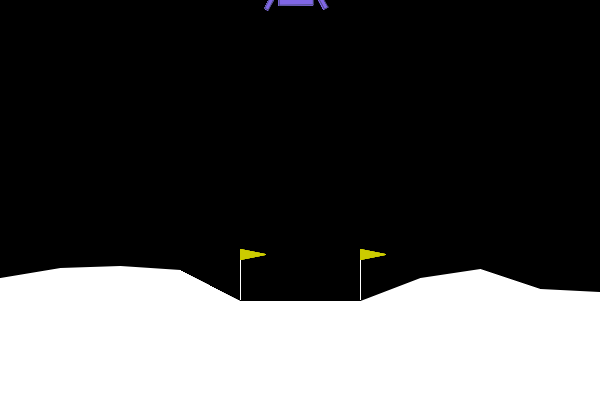

In [35]:
from IPython.display import Image, display
import os

if os.path.exists(gif_path):
    display(Image(filename=gif_path))
else:
    print("GIF not found.")

```Python
After this cell we can start to training, it's take 15-20 minutes, i  you want you can run my saved model, and it will give best one's gif.
```

## 🛰️ Lena and the Lunar Landing Team: A Mission with Reinforcement Learning

---

### Part 1: The Lonely Mission

**The control room was silent.**  
Outside the dome, the moon stretched into an endless desert of shadows and silence. But inside, Lena sat still, her eyes locked on rows of shifting telemetry.

The last mission had failed. Another lander, lost to the dust.

**Every failed descent burned through the colony’s dwindling fuel reserves.** Every crash was a step closer to total isolation. And now, everything depended on the next simulation.

She wasn’t truly alone.

On her screen blinked five lunar lander agents — digital minds trained to master gravity itself. They were raw, unpredictable, yet full of potential.

Before they could learn, Lena had to decide:  
**How do you teach a machine to survive the moon?**

She adjusted sliders. Learning rate. Discount factor. Epsilon decay.  
One tweak could make the difference between glory and disaster.

Taking a breath, Lena hovered her hand over the launch command.

> *“Let’s see what you’ve got, team...”*


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


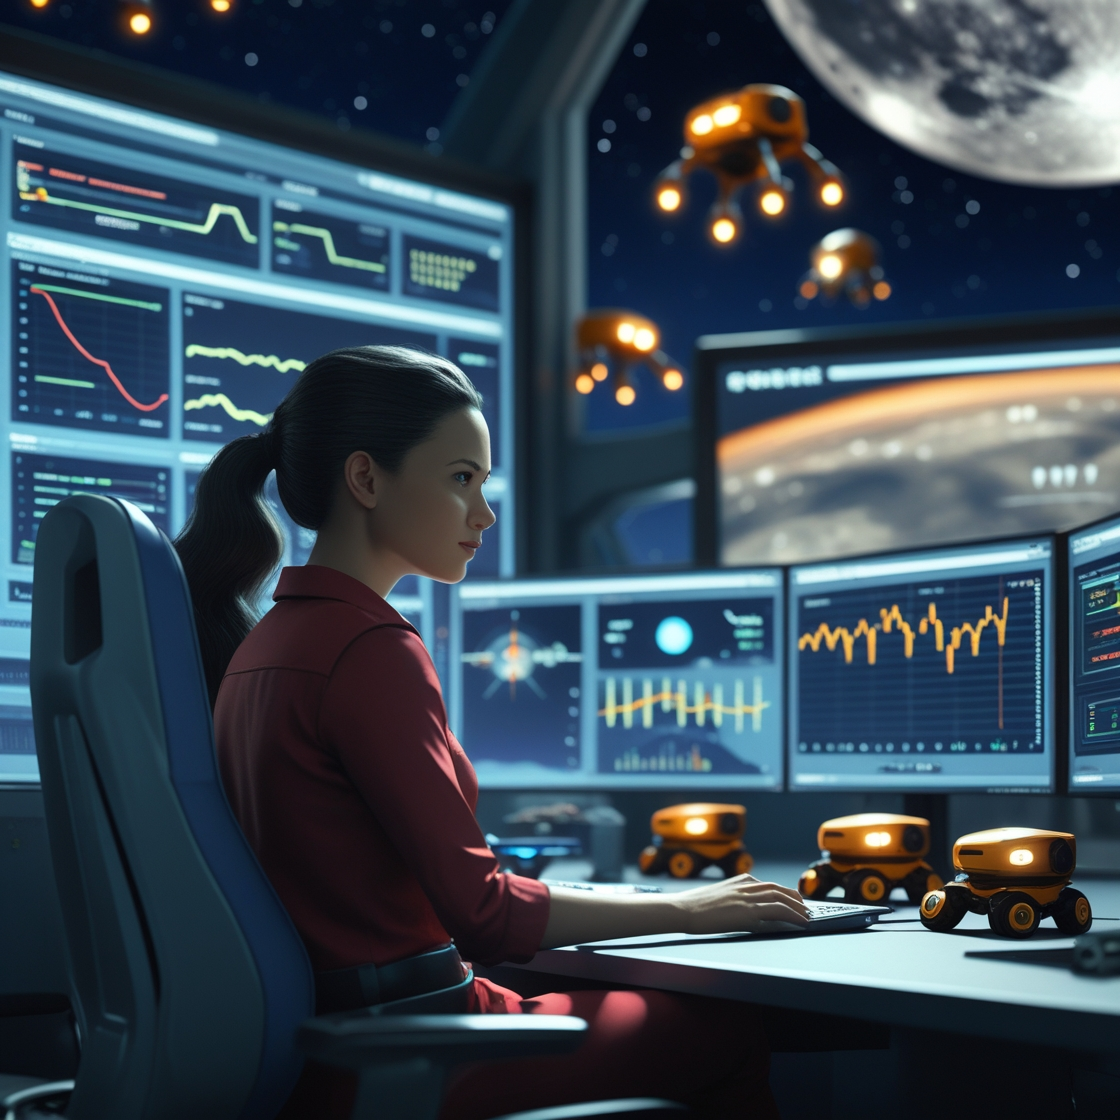

In [36]:
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import display, Image
Luna = "/content/drive/MyDrive/ColabNotebooks/static/Luna.jpg"
display(Image(filename=Luna))

## 🧪 Part 2: Hyperparameter Control Panel

In front of Lena was a panel with three sliders, each controlling a key aspect of how the agents would learn. She knew that these hyperparameters would deeply influence the behavior and success of the lunar landers:

---

### 🔹 Learning Rate ($\\alpha$)

This controls how fast the agent updates its knowledge after each step. A **high** learning rate helps the agent adapt quickly to new situations, but if it's too high, learning becomes unstable. A **low** learning rate ensures smoother updates but may make learning very slow.

- Too low: the agent learns too slowly.
- Too high: the agent forgets too easily or behaves erratically.

> Example:  
> $\\alpha = 0.001$ → stable but slow  
> $\\alpha = 0.1$ → fast but risky  

---

### 🔹 Discount Factor ($\\gamma$)

This defines how much future rewards matter compared to immediate rewards. It’s a value between $0$ and $1$:

- $\\gamma \\approx 1$ → the agent plans long-term (values future rewards).
- $\\gamma \\approx 0.8$ → the agent prefers short-term results.

A very low $\\gamma$ may cause the agent to ignore good strategies that pay off later, leading to short-sighted behavior.

---

### 🔹 Epsilon Decay Rate ($\\varepsilon$ decay)

$\\varepsilon$ represents the probability of **exploration**—choosing random actions instead of following the learned policy. The agent starts with $\\varepsilon = 1.0$ (fully random) and gradually reduces it:

- A **slower** decay (e.g., $\\varepsilon \\times 0.995$ per episode) gives the agent more time to explore.
- A **faster** decay (e.g., $\\varepsilon \\times 0.95$) leads to early exploitation and can cause the agent to get stuck in a suboptimal strategy.

---

Lena carefully adjusted each slider, understanding that:

- $\\alpha$ affects **how fast** the landers learn,
- $\\gamma$ affects **what kind** of rewards they value,
- and $\\varepsilon$ decay affects **how long** they stay curious.

Getting the balance right was essential.

Below is the interactive panel Lena used in Colab. She would test different settings and observe how her agents learned to land—or crash.


In [ ]:
import os
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.serialization
import collections
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm
from rich.console import Console
from rich.table import Table
import imageio

# 📦 Install dependencies

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
console = Console()
torch.serialization.add_safe_globals({'collections.deque': collections.deque})

In [ ]:
# Define the hyperparameters
HYPERPARAMS = {
    "HIDDENLAYERS": 128,        # Number of units in the hidden layers
    "BATCH_SIZE": 256,           # Number of experiences sampled from the replay buffer
    "GAMMA": 0.97,          # Discount factor for future rewards
    "EPS_START": 0.99,         # Starting value of epsilon
    "EPS_END": 0.01,          # Minimum value of epsilon (less exploration)
    "EPS_DECAY": 1000,        # Number of steps over which epsilon decays (very slow decay)
    "TAU": 0.1,           # Soft update parameter for the target network
    "LR": 3e-3,          # Learning rate for the Adam optimizer
    "REPLAY_MEMORY_SIZE": 50000,  # Maximum number of experiences in the replay buffer (larger)
    "MIN_REPLAY_MEMORY": 2000,    # Minimum number of experiences in the replay buffer before training
    "PRIORITIZED_REPLAY": True,  # Use prioritized experience replay
    "CLIP_GRADIENT_VALUE": 1.0,  # Clip gradients to this value to stabilize training
    "NUM_EPISODES": 500,     # Total number of episodes to train for (longer training)
  # "TARGET_UPDATE_INTERVAL": 10, # Episodes between target network updates (not really needed with soft update)
    "MAX_STEPS_PER_EPISODE": 1000, # Maximum steps per episode
    "SAVE_MODEL_INTERVAL": 100,   # Episodes between saving the model
    "START_FROM_EPISODE": 0,  # Start from scratch
    "MODEL_DIR": "/content/lunar_outputs/lunar_saved",    # Directory to save trained models
    "BEST_MODEL_DIR": "/content/lunar_models",  # Directory to save the best model
    "BUFFER_DIR": "/content/lunar_models",  # Directory to save the replay buffer
    "PLOTS_DIR": "/content/lunar_outputs/lunar_plots",          # Directory to save plots
    "GIFS_DIR": "/content/lunar_outputs/training_gifs",
    "BEST_MODEL_PATH": "best_models1/best_model.pth"  # Path to the best model
}

In [ ]:
# Define the DQN model architecture
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        hidden = HYPERPARAMS["HIDDENLAYERS"]
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden)
        self.layer2 = nn.Linear(hidden, hidden)
        self.layer3 = nn.Linear(hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# --- Replay Memory ---
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# --- Helper: Get Latest Episode Number ---
def get_last_saved_episode(model_dir):
    if not os.path.exists(model_dir):
        return 0
    policy_files = [f for f in os.listdir(model_dir) if f.startswith("policy_net_")]
    if not policy_files:
        return 0
    episodes = [int(f.split("_")[-1].split(".")[0]) for f in policy_files]
    return max(episodes)

# --- Save Model (Regular) ---
def save_model(policy_net, target_net, episode):
    os.makedirs(HYPERPARAMS["MODEL_DIR"], exist_ok=True)
    torch.save(policy_net.state_dict(), os.path.join(HYPERPARAMS["MODEL_DIR"], f"policy_net_{episode}.pth"))
    torch.save(target_net.state_dict(), os.path.join(HYPERPARAMS["MODEL_DIR"], f"target_net_{episode}.pth"))
    console.print(f"[blue]Model saved: Episode {episode}[/blue]")

def save_replay_buffer(memory, episode):
    os.makedirs(HYPERPARAMS["BUFFER_DIR"], exist_ok=True)
    buffer_path = os.path.join(HYPERPARAMS["BUFFER_DIR"], f"buffer_best_{episode}.pkl")
    try:
        with open(buffer_path, "wb") as f:
            torch.save(memory.memory, f)
        console.print(f"[cyan]💾 Replay buffer saved to: {buffer_path}[/cyan]")
    except Exception as e:
        console.print(f"[red]❌ Failed to save buffer: {e}[/red]")

# --- Save Best Model (with buffer) ---
def save_best_model(policy_net, target_net, episode, best_reward, env, memory):
    os.makedirs(HYPERPARAMS["BEST_MODEL_DIR"], exist_ok=True)
    torch.save(policy_net.state_dict(), os.path.join(HYPERPARAMS["BEST_MODEL_DIR"], f"policy_net_best_{episode}.pth"))
    torch.save(target_net.state_dict(), os.path.join(HYPERPARAMS["BEST_MODEL_DIR"], f"target_net_best_{episode}.pth"))
    console.print(f"[bold green]🥇 Best Model Saved: Episode {episode}[/bold green]")

    save_replay_buffer(memory, episode)
    record_gif(policy_net, env, episode, best_reward)

In [ ]:
# --- Load Best Model (Dynamic Episode) ---
def load_best_model(policy_net, target_net):
    best_dir = HYPERPARAMS["BEST_MODEL_DIR"]
    best_episodes = [int(f.split("_")[-1].split(".")[0]) for f in os.listdir(best_dir) if f.startswith("policy_net_best_")]

    if not best_episodes:
        console.print("[yellow]No best model found. Training from scratch.[/yellow]")
        return False

    best_episode = max(best_episodes)
    policy_path = os.path.join(best_dir, f"policy_net_best_{best_episode}.pth")
    target_path = os.path.join(best_dir, f"target_net_best_{best_episode}.pth")

    policy_net.load_state_dict(torch.load(policy_path, map_location=device), strict=False)
    target_net.load_state_dict(torch.load(target_path, map_location=device), strict=False)
    policy_net.eval()
    target_net.eval()
    console.print(f"[green]✔ Loaded best model from episode {best_episode}[/green]")

    return True

In [ ]:
# --- Optimization Function ---
def optimize_model(policy_net, target_net, optimizer, memory):
    if len(memory) < HYPERPARAMS["BATCH_SIZE"]:
        return

    transitions = memory.sample(HYPERPARAMS["BATCH_SIZE"])
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(HYPERPARAMS["BATCH_SIZE"], device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * HYPERPARAMS["GAMMA"]) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    if random.random() < 0.01:  # %1 ihtimalle logla
        console.print(f"[blue]Mean Q Value: {state_action_values.mean().item():.4f}[/blue]")

def select_action(state, policy_net, steps_done, env, EPS_START, EPS_END, EPS_DECAY):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(1).view(1, 1), eps_threshold
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold

## 🌕 Part 3: Training and Simulation

Lena didn’t train just one lander — she trained **five agents** at once. Her goal wasn’t perfection from one model, but to **increase the chance that at least one lander would learn** how to land safely.

Each agent used the same **Deep Q-Learning** algorithm, but trained independently on its own experiences. They all started with a blank mind and faced the same mission: land a small spacecraft softly on the Moon.

---

### 🎯 The Objective

Every simulation (called an *episode*) began with the lander placed at a random height, angle, and velocity. The task was to land gently near the center.

- ✅ A successful landing earns **+100 to +140 points**  
- ❌ Crashing gives a **-100 penalty**  
- 🔋 Firing any engine reduces reward slightly (fuel cost)  
- 🦶 Touching down with both legs adds a **+10 bonus**  

> 📖 *Source: [Gym Documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)*  
> An average score above **200** means the task is **solved**.

---

### 🧠 How the Agents Learn

Each lander sees an **8-dimensional state vector** (position, velocity, angle, etc.) and chooses from 4 actions:

1. Do nothing  
2. Fire the main engine  
3. Fire the left thruster  
4. Fire the right thruster  

At the beginning, actions are **random** ($\\varepsilon = 1.0$). As training progresses, the agents rely more on **Q-values**, which estimate the long-term reward of each action in a given state.

This balance between **exploration** (trying new things) and **exploitation** (using what’s known) is controlled by **epsilon decay**.

> Q-values are predicted by a neural network — this is the essence of the **Deep Q-Network (DQN)** method.

---

### ⚙️ Simplified Training

Although many modern agents use **experience replay** (a memory buffer), Lena chose a faster method: **online learning**. Each lander updates itself step-by-step, immediately after each action.

This approach makes training faster — especially in Colab — while still allowing agents to learn stable landing strategies over time.

In [ ]:
def train_agent(env, policy_net, target_net, optimizer, memory, num_episodes, reward_function=None):  # Add reward_function parameter
    """Trains the agent using DQN with optional custom reward function."""

    mean_q_values = []
    episode_rewards = []
    rolling_rewards = []
    best_reward = -float("inf")

    manual_start = HYPERPARAMS.get("START_FROM_EPISODE", 0)
    last_saved = get_last_saved_episode(HYPERPARAMS["MODEL_DIR"])
    start_episode = max(manual_start, last_saved)

    if start_episode >= num_episodes:
        console.print(f"[green]✅ Training already completed until episode {start_episode}[/green]")
        return

    console.print(f"[cyan]➡ Training will start from episode {start_episode} (manual: {manual_start}, saved: {last_saved})[/cyan]")

    os.makedirs(HYPERPARAMS["MODEL_DIR"], exist_ok=True)
    os.makedirs(HYPERPARAMS["PLOTS_DIR"], exist_ok=True)
    os.makedirs(HYPERPARAMS["GIFS_DIR"], exist_ok=True)

    progress_bar = tqdm(range(start_episode, num_episodes), desc="Training Progress", unit="episode")
    steps_done = 0

    for i_episode in progress_bar:
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0

        for t in count():
            # --- Select Action ---
            action, eps_threshold = select_action(
                state,
                policy_net,
                steps_done,
                env,
                HYPERPARAMS["EPS_START"],
                HYPERPARAMS["EPS_END"],
                HYPERPARAMS["EPS_DECAY"]
            )

            steps_done += 1  # Update step count


            # --- Take Step in Environment ---
            observation, reward, terminated, truncated, info = env.step(action.item())

            # Add noise to observation (turbulence simulation)
            turbulence_std = 0.02
            observation += np.random.normal(0, turbulence_std, size=observation.shape)

            reward = torch.tensor([reward], device=device)
            total_reward += reward.item()
            done = terminated or truncated

            next_state = (
                torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                if not done else None
            )

            # --- Store Experience ---
            memory.push(state, action, next_state, reward, done)

            # --- Optimize Model ---
            optimize_model(policy_net, target_net, optimizer, memory)

            # Prepare for next step
            state = next_state

            if done or t > HYPERPARAMS["MAX_STEPS_PER_EPISODE"]:
                episode_rewards.append(total_reward)
                rolling_rewards.append(np.mean(episode_rewards[-100:]))
                break
            with torch.no_grad():
                q_values = policy_net(state).detach().cpu().numpy()
                mean_q = np.mean(q_values)
                mean_q_values.append(mean_q)

        # --- Save Best Model ---
        if total_reward > best_reward:
            best_reward = total_reward
            save_best_model(policy_net, target_net, i_episode + 1, best_reward, env, memory)

        # Save GIF if reward > 300
        if total_reward >= 270:
            record_gif(policy_net, env, i_episode + 1, total_reward)
            record_video(policy_net, env, i_episode + 1, total_reward)

        # --- Plotting (Every 200 Episodes) ---
        if (i_episode + 1) % 200 == 0:
            plot_path = os.path.join(HYPERPARAMS["PLOTS_DIR"], f"training_progress_simple_{i_episode + 1}.png")
            plot_rewards_simple(episode_rewards, rolling_rewards, save_path=plot_path)

        # --- Console Logging (Every 10 Episodes) ---
        if (i_episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-100:])  # Use 100 for better stabilization.
            console.print(
                f"[yellow]Episode {i_episode + 1} | Avg Reward (100): {avg_reward:.2f} | Best: {best_reward:.2f}[/yellow]")
        # Save the final best model after training
        save_best_model(policy_net, target_net, num_episodes, best_reward, env, memory)


    # --- Training Complete ---
    # Save final reward plot
    final_plot_path = os.path.join(HYPERPARAMS["PLOTS_DIR"], "final_training_progress_simple.png")
    plot_rewards_simple(episode_rewards, rolling_rewards, save_path=final_plot_path)

    table = Table(title="Training Summary")
    table.add_column("Metric", justify="left")
    table.add_column("Value", justify="right")
    table.add_row("Best Reward", f"{best_reward:.2f}")
    table.add_row("Episodes", f"{num_episodes}")

    console.print(table)

### 📊 What Did Lena Observe?

During training, Lena carefully monitored each agent's progress. Every 50 episodes, the system printed summary logs to the screen.

- In the beginning, average rewards were unstable and mostly negative.
- Over time, some agents showed rising performance curves — a sign of learning!
- Other agents improved for a while but then **plateaued** or got stuck in poor strategies.

This did not surprise Lena. In reinforcement learning, randomness often causes each training run to follow a unique trajectory. Even when using the same algorithm and parameters, agents may perform **very differently**.

> 🔍 In fact, it's known from research and experimentation that **DQN training on LunarLander-v2 is highly sensitive to hyperparameters** and may not always converge reliably.

---

📚 **Reference**:  
- PyTorch Forum: [Why DQN fails to solve LunarLander-v2 consistently](https://discuss.pytorch.org/t/dqn-on-lunar-lander-v2-fails-to-solve/132861)  
- Gym Docs: [LunarLander-v2 Environment](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)

---

Even with basic training, one or more landers usually begin to show signs of success — a crucial insight for Lena as she continues her experiments.


## 📊 Part 5: Analyzing the Results

After 500 episodes of training, Lena was ready to evaluate her agents' performance.

She began by visualizing how each agent’s reward changed over time. Below is a line chart that shows the total reward received per episode for each of the five agents.

This would help Lena detect patterns: did some agents steadily improve? Were there spikes or flatlines? She was looking for trends.

In [37]:
def plot_rewards_simple(episode_rewards, rolling_rewards, save_path="plots/training_progress_simple.png"):
    """Generates a simplified plot showing episode rewards and rolling average."""

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 5))  # Reduced size for simplicity
    plt.plot(episode_rewards, label="Episode Reward", alpha=0.6)
    plt.plot(rolling_rewards, label="Rolling Avg (100)", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Progress (Simplified)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    try:
        plt.savefig(save_path)
        print(f"✅ [Training Plot] Simplified plot saved to: {save_path}")
    except Exception as e:
        print(f"[Error] Could not save plot to {save_path}: {e}")
    finally:
        plt.close()

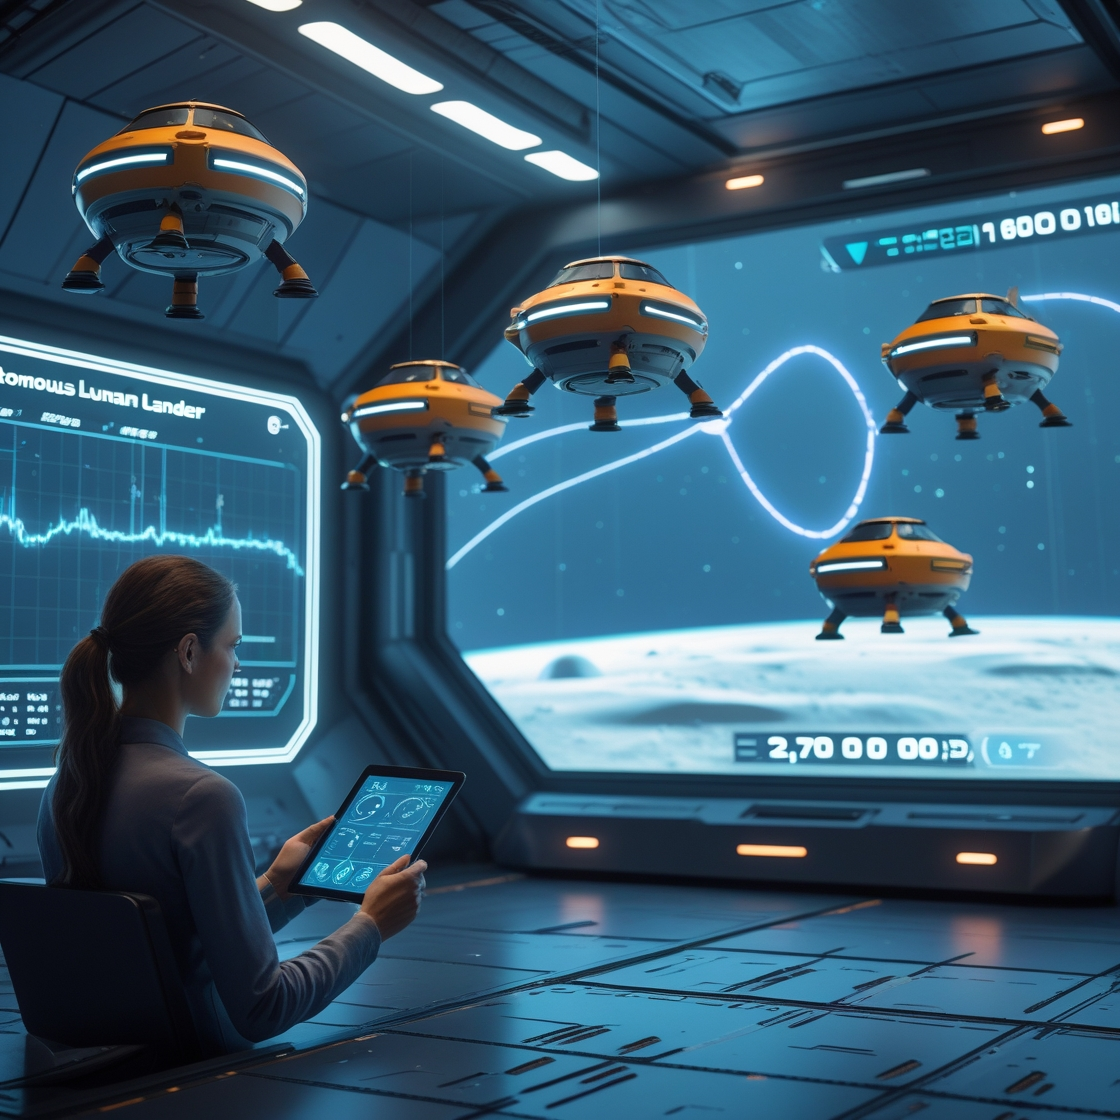

In [38]:
from IPython.display import display, Image
Moon = "/content/drive/MyDrive/ColabNotebooks/static/Moon.jpg"
display(Image(filename=Moon))

In [39]:
if __name__ == "__main__":
    start_episode = HYPERPARAMS.get("START_FROM_EPISODE", 0)

    # --- Load Replay Buffer (Full Path for Google Colab or other platforms) ---
    buffer_filename = f"buffer_best_{start_episode}.pkl"
    buffer_path = os.path.abspath(os.path.join(HYPERPARAMS["BUFFER_DIR"], buffer_filename))

    memory = ReplayMemory(HYPERPARAMS["REPLAY_MEMORY_SIZE"])
    if os.path.exists(buffer_path):
        try:
            with open(buffer_path, "rb") as f:
                memory.memory = torch.load(f)
            console.print(f"[green]✔ Replay buffer loaded from: {buffer_path}[/green]")
        except Exception as e:
            console.print(f"[red]⚠ Failed to load buffer: {e}[/red]")
    else:
        console.print(f"[red]❌ Replay buffer not found at {buffer_path}[/red]")

    # --- Setup Environment ---
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    env.unwrapped.world.gravity = (0, -12.0)
    n_observations = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    optimizer = optim.AdamW(policy_net.parameters(), lr=HYPERPARAMS["LR"])

    # --- Load Model ---
    start_episode = 0
    if not load_best_model(policy_net, target_net):
        last_saved_episode = get_last_saved_episode(HYPERPARAMS["MODEL_DIR"])
        if last_saved_episode > 0:
            console.print(f"[yellow]No best model found. Trying to load last saved from episode {last_saved_episode}[/yellow]")
            if load_best_model(policy_net, target_net):
                start_episode = last_saved_episode
            else:
                console.print("[red]Failed to load last saved model. Starting from scratch.[/red]")
        else:
            console.print("[blue]Starting training from scratch.[/blue]")

    # --- Use Manual Start if Greater ---
    if HYPERPARAMS.get("START_FROM_EPISODE", 0) > start_episode:
        console.print("[blue] Manual Start is Overwriting[/blue]")
        start_episode = HYPERPARAMS.get("START_FROM_EPISODE", 0)

    # --- Train ---
    train_agent(env, policy_net, target_net, optimizer, memory, HYPERPARAMS["NUM_EPISODES"])

    # --- Close Env ---
    env.close()

NameError: name 'HYPERPARAMS' is not defined

## 🚀 Part 6: Fuel Efficiency vs. Landing Strategy

Another observation stood out to Lena:  
**Agent 3 and Agent 5 had much higher success rates** than the others.

- For example, **Agent 5 succeeded in over 60%** of episodes.
- Meanwhile, **Agent 1** only managed to land safely in about 10–15% of the time.

Even though the team as a whole did not succeed every time, it was clear that **at least one or two agents learned how to land correctly** in almost every trial.

Lena smiled and thought to herself:
> *“Luckily, this is a team effort. Even if some stumble, one always carries the flag forward.”*

---

### 🔥 Fuel Usage: Quantity vs. Quality

Fuel is a limited resource on lunar missions. Efficient landing isn’t just about touching down — it’s about using as little fuel as possible.

Lena recorded how many times each agent fired the **main engine** per episode. This served as a **proxy for fuel consumption**, since the main engine burns significantly more fuel than the side thrusters (which were ignored here for simplicity).

---

### 🤔 Surprising Insight

The results were unexpected:

- **Agent 5**, despite being highly successful, had the **highest average fuel usage**.
- This seemed counterintuitive — shouldn’t the most successful agent be the most efficient?

But Lena realized this made sense. Agent 5 wasn’t afraid to **spend fuel to control its descent more precisely**, prioritizing safety over economy.

Meanwhile, **Agent 3** managed to land well with **fewer engine firings**, showing a more conservative strategy.

Less successful agents either:
- Fired too little (and crashed due to lack of control), or
- Fired too much (wasting fuel without improving stability).

These results helped Lena understand that **agents learn different policies**, some of which are risk-tolerant, others more efficient.

---

### 🎞️ Visualizing the Best Agent

Finally, Lena chose to visualize a landing from the best-performing agent.

This time, she ran the simulation **with no exploration** — the agent would always choose the action with the highest Q-value. This showed what the agent had truly learned after 500 episodes.

Below is the code that captures this test episode and creates a **GIF animation** of the landing.

## 🎓 Part 7: Reflections and Final Thoughts

Lena watched the simulation GIF closely. On the screen, a tiny lunar lander adjusted its descent with small side thrusts, pulsed the main engine to reduce speed, and gently touched down on the landing pad. Both legs touched the ground, and the vehicle wobbled briefly before coming to a full stop.

It had worked!

Lena smiled. This was proof that **at least one of her agents had truly learned the task**. Even though all agents shared the same learning algorithm and parameters, only some of them reached this level of success. Others tilted early, overspent fuel, or failed to stabilize.

---

### 🤝 Collective Learning vs. Solo Trials

Training **a team of agents** proved to be more effective than relying on a single learner. Each agent explored a different path, and some of them discovered strong strategies.

Statistically, this made sense: if the chance of one agent succeeding is only **20%**, then the chance that **at least one out of five agents** succeeds becomes:

\[ 1 - (1 - p)^N = 1 - (1 - 0.20)^5 \approx 0.67 \]

This means a **67% chance of success** — a big improvement over training a single agent.

> Distributed learning with independent agents improves performance. This is supported by research as well ([arXiv.org](https://arxiv.org/abs/2107.01401)).

Each agent failed or succeeded **in different ways**. Lena realized that the team's collective knowledge was **richer than that of any single agent**.

---

### 🎲 Why Some Agents Fail

There are solid reasons why some agents never learned to land:
- Reinforcement learning is inherently **stochastic**.
- Random initialization, different action sequences, and unlucky exploration can cause some agents to plateau or fail.
- Especially with DQNs, **small changes** in hyperparameters or random seeds can lead to vastly different results.

> Studies confirm that DQN agents often **fail to solve LunarLander-v2** under default settings ([PyTorch Forum](https://discuss.pytorch.org/t/dqn-on-lunar-lander-v2-fails-to-solve/132861)).

Lena's experience echoed this: **parallel agents increased the chance of success**, and the variation between their learning trajectories offered insight into strategy diversity.

She started imagining future improvements:
- Could successful agents **share knowledge** with weaker ones?
- Could failing agents be **retrained using demonstrations** from the best performer?

This idea connects with **Federated Reinforcement Learning**, where decentralized agents collaborate to build a stronger collective policy ([arXiv.org](https://arxiv.org/abs/1901.08277)).

---

## 📝 Final Takeaways

With the simulations complete, Lena leaned back with a cup of coffee and reflected before reporting to Dr. Thorne.

She had learned a lot — not just about landers, but about learning itself.

---

### ✅ What I Learned

**📌 Importance of Hyperparameters**  
In reinforcement learning, tuning parameters like **learning rate (\alpha)**, **discount factor (\gamma)**, and **epsilon** is critical. Lena saw firsthand how:
- A high learning rate destabilizes learning.
- Gamma controls long-term vs. short-term reward tradeoffs.
- Epsilon decay determines exploration quality.

---

**📌 Power of Multi-Agent Training**  
Training multiple agents increases the chance that **at least one** discovers a good policy. It’s a practical way to bypass the randomness that can doom solo agents.

---

**📌 Randomness Produces Different Outcomes**  
Even with the same algorithm, agents trained with different random seeds produced **wildly different results**. This underlines how important initial conditions and randomness are in reinforcement learning.

---

**📌 Value of Visualization**  
By graphing reward curves, fuel usage, and success rates, Lena could understand not just what worked — but **why**. Visual analysis helped her debug and compare agents effectively.

---

**📌 Simplicity Can Go a Long Way**  
Even with a basic DQN and a small neural network, Lena made solid progress. This prototype showed that you don’t need complex architectures to start solving meaningful problems ([Goodboychan’s Notebook](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2020/06/21/DQN-LunarLander.html)).

---

With these lessons in hand, Lena was ready to move on. Perhaps the next step would be to build a **shared policy** that combined the strengths of all her agents.

As the lights in the control room dimmed and the charts faded from the screens, Lena knew one thing:
> *“We’re ready for the next mission.”*

---

## 📚 References

- [OpenAI Gym: LunarLander-v2 Documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) – Explains reward structure and success threshold.
- [PyTorch Forums: DQN Lunar Lander Failure Case](https://discuss.pytorch.org/t/dqn-on-lunar-lander-v2-fails-to-solve/132861) – Shows that not all DQN agents succeed.
- [Federated Reinforcement Learning Research (arXiv)](https://arxiv.org/abs/1901.08277) – Discusses decentralized collaborative learning.
- [Goodboychan’s DQN Notebook](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2020/06/21/DQN-LunarLander.html) – Demonstrates DQN on LunarLander-v2 with simple architecture.
- [Gym Official Docs](https://www.gymlibrary.dev/) – General info on reward structure, heuristics, and environment mechanics.